In [1]:
# set up imports
import pandas as pd, numpy as np, seaborn as sns
from tabulate import tabulate
import statsmodels
import arch
import matplotlib
matplotlib.use('qt5agg')

# configure plot style
import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams["figure.figsize"] = (12,5)
plt.rcParams['figure.constrained_layout.use'] = False
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['lines.linewidth'] = 0.8
save_plot_to =  r'C:\\Users\joche\OneDrive\03 TUM - TUM-BWL\Semester 8\01 Bachelorarbeit\04 Results\Plots/'

In [2]:
# load data: new_btc.txt, created with M4
index_name = 'date'
btc = pd.read_csv('Data/btc_new.txt', index_col=0)
btc.index = pd.DatetimeIndex(btc.index, normalize=True).normalize()
btc

,btc
date,
2015-08-07,279.58
2015-08-10,264.47
2015-08-11,270.39
2015-08-12,266.38
2015-08-13,264.08
...,...
2020-06-18,9411.84
2020-06-19,9288.02
2020-06-22,9648.72


In [3]:
# split data in pre and post bubble 2018
pre_bubble_end_date = '2017-12-01'
post_bubble_start_date = '2018-02-01'

# pre bubble df
btc_pre = btc[:pre_bubble_end_date]

# post bubble df
btc_post = btc[post_bubble_start_date:]

In [4]:
# define overview-printing function of dataframe
def dates_overview(dataframe):
    print('start_date:\t', dataframe.index[0])
    print('end_date:\t', dataframe.index[-1])
    print('len df:\t\t', len(dataframe))

# define train/test-splitting function of dataframe
def split_traintest_df(dataframe):
    train_size = int(len(dataframe) * 0.8)
    df_train, df_test = dataframe[0:train_size], dataframe[train_size:]
    # create dataframe for printout
    data = {'Dataframe': ['dataframe', 'df_train', 'df_test'],
            'date_start': [dataframe.index[0], df_train.index[0], df_test.index[0]],
            'date_end': [dataframe.index[-1], df_train.index[-1], df_test.index[-1]],
            'nobs': [len(dataframe), len(df_train), len(df_test)]}
    df_print = pd.DataFrame(data, columns=['Dataframe','date_start','date_end','nobs'])
    print(df_print)
    return df_train, df_test

# define log-taking and relabeling function
def log_of_df(dataframe):
    df_log = np.log(dataframe)
    new_cols = list()
    for i in df_log.columns:
        new_cols.append(i+'_log')
    df_log.columns = new_cols
    # fill na value of negative oil price on 2020-04-20 with 0
    df_log.fillna(value=0, inplace=True)
    return df_log

# define first difference-taking function of dataframe
def diff_of_df(dataframe):
    df_train_log_diff = dataframe.diff()
    # relabel columns
    new_cols = list()
    for i in df_train_log_diff.columns:
        new_cols.append(i+'_diff')
    df_train_log_diff.columns = new_cols
    return df_train_log_diff

# define return creating function of dataframe
def create_returns(dataframe_train):
    dataframe_train_log = log_of_df(dataframe_train)
    dataframe_returns = diff_of_df(dataframe_train_log)
    dataframe_returns.columns = ['btc_ret']
    return dataframe_train_log, dataframe_returns

# define log and ret + ACF & PACF plotting function for dataframe_log, dataframe_ret
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
def plot_acf_pacf(dataframe_log, dataframe_ret):
    fig, axs = plt.subplots(3,2)
    axs[0][0].plot(dataframe_log.iloc[1:], color='black')
    axs[0][0].set_title('btc_log')
    axs[0][1].plot(dataframe_ret.iloc[1:], color='black')
    axs[0][1].set_title('btc_ret')
    plot_acf(dataframe_log, color='black', ax=axs[1][0], markersize=2)
    plot_acf(dataframe_ret.iloc[1:], color='black', ax=axs[1][1], markersize=2)
    plot_pacf(dataframe_log, color='black', ax=axs[2][0], markersize=2)
    plot_pacf(dataframe_ret.iloc[1:], color='black', ax=axs[2][1], markersize=2)
    fig.set_size_inches(12,5)
    fig.tight_layout()
    return fig

# define adf- and pp-testing of dataframe with latex-printout on/off
from arch.unitroot import ADF, PhillipsPerron
def stationarity_tests(dataframe, latex):
    for col in dataframe:
        adf = ADF(dataframe[col])
        pp = PhillipsPerron(dataframe[col])
        if latex is False:
            # write summary as plain text to std.out
            print('Timeseries:\t',col,'\n',
                  adf.summary(),'\n\n',pp.summary(),'\n\n\n')
        else:
            # write summary as latex to file
            with open(save_plot_to + 'Stationarity_Tests_LaTeX.txt', 'a') as myfile:
                myfile.write('Timeseries:\t'+col+'\n'
                         +adf.summary().as_latex()+'\n\n'
                         +pp.summary().as_latex()+'\n\n\n')
                
# define stationaritiy table-generating function of a dataframe filepath
def stationarity_table_aslatex_from_df(filepath):
    # read in dataframe from .txt file
    stationarity_dataframe = pd.read_csv(save_plot_to+filepath, delimiter='\s+', header=0)
    # print dataframe as latex output
    print(tabulate(stationarity_dataframe, headers=stationarity_dataframe.columns, showindex=False, tablefmt="latex"))

# define auto-ARIMA function for a dataframe_ret
import pmdarima as pm
import warnings
warnings.filterwarnings('ignore')
def auto_arima_optimal_fit_of(dataframe_ret, max_p, max_q):
    model_auto = pm.auto_arima(dataframe_ret, start_p=0, start_q=0,
                               max_p=max_p, max_q=max_q,
                               test='adf',
                               m=1,
                               d=None,
                               trace=True,
                               error_action='ignore',
                               suppress_warnings=True,
                               seasonal=False,
                               stepwise=True)
    return model_auto

# define manually verifying function for dataframe_ret
import pmdarima as pm
import warnings
warnings.filterwarnings('ignore')
def arima_fit_of(dataframe_ret, max_p, max_q, latex):
    for p in range(max_p):
        for q in range(max_q):
            temp_model = pm.ARIMA(order=(p,0,q))
            temp_fitted = temp_model.fit(dataframe_ret)
            if latex is False:
                # write summary as plain text to std.out
                print('Current order: {0},0,{1}\n'.format(p,q),
                temp_fitted.summary(),'\n')
            else:
                # write summary as latex to file
                with open(save_plot_to + 'M2_ARIMA_configuratios_LaTeX.txt', 'a') as myfile:
                        myfile.write('Current order: {0},0,{1}\n'.format(p,q)+
                                     temp_fitted.summary().as_latex()+'\n\n')

# define rolling forecast function for dataframe and p,q values
from sklearn.metrics import mean_squared_error as mse
def arima_rolling_forecast(dataframe, p, q):
    # create train and test dataframes
    train_size = int(len(dataframe) * 0.8)
    dataframe_train, dataframe_test = dataframe[0:train_size], dataframe[train_size:]
    index = len(dataframe_train) - 1
    # initialize lists
    pred_val_btc = list()
    lo_conf_int_btc = list()
    up_conf_int_btc = list()
    ausreisser_ctr = 0
    # rolling forecast
    for i in range(len(dataframe_test)):
        # input data, dependent on i
        input_data = log_of_df(dataframe).diff().values[max(p,q)+1:index + i]
        # fit model and predict 1 step
        dataframe_arima = pm.ARIMA(order=(p,0,q))
        dataframe_arima_fitted = dataframe_arima.fit(y=input_data, disp=False)
        dataframe_arima_result = dataframe_arima_fitted.predict(n_periods=1, return_conf_int=True)
        # obtain absolute (inversed) btc values for mean prediction, upper- and lower confidence interval
        yhat_btc = np.exp(dataframe_arima_result[0][0] + np.log(dataframe).iloc[:,0][index+i])
        lo_conf_btc_val = np.exp(dataframe_arima_result[1][0][0] + np.log(dataframe).iloc[:,0][index+i])
        up_conf_btc_val = np.exp(dataframe_arima_result[1][0][1] + np.log(dataframe).iloc[:,0][index+i])
        if (dataframe.iloc[:,0][index+i+1] > up_conf_btc_val) or (dataframe.iloc[:,0][index+i+1] < lo_conf_btc_val):
            ausreisser_ctr += 1
        pred_val_btc.append(yhat_btc)
        lo_conf_int_btc.append(lo_conf_btc_val)
        up_conf_int_btc.append(up_conf_btc_val)
    # return [0]: mse, [1]: ausreisser ctr, [2]: predictions, [3]: lo_confint, [4]: up_confint
    return (np.sqrt(mse(pred_val_btc, dataframe_test.iloc[:,0].values)), ausreisser_ctr,
            pred_val_btc, lo_conf_int_btc, up_conf_int_btc)

# define series-generating and plotting function for dataframe_arima_pred_result
def plot_arima_pred_result(dataframe, dataframe_train, dataframe_test, dataframe_arima_pred_result):
    # make series for plotting pred. vs. actual
    index_pred = np.arange(len(dataframe_train) + 1, len(dataframe) + 1)
    pred_val_btc_series = pd.Series(dataframe_arima_pred_result[2], index=index_pred)
    test_series_btc = pd.Series(dataframe_test.iloc[:,0].values, index=index_pred)
    lo_conf_int_btc_series = pd.Series(dataframe_arima_pred_result[3], index=index_pred)
    up_conf_int_btc_series = pd.Series(dataframe_arima_pred_result[4], index=index_pred)
    # create plot: 
    fig, axs = plt.subplots(1,2)
    axs[0].plot(dataframe_train.iloc[:,0].values, label= r'$btc_T$', color='black')
    axs[0].plot(test_series_btc, label= r'$btc_{T+h}$', color='green')
    axs[0].plot(pred_val_btc_series, label= r'$\hat{btc}_{T+h}$', color= 'red')
    axs[0].fill_between(lo_conf_int_btc_series.index, lo_conf_int_btc_series, up_conf_int_btc_series, color='k', alpha=0.1)
    axs[0].legend(loc='upper left')
    axs[0].title.set_text('Gesamter Zeitraum')
    axs[1].plot(test_series_btc, label= r'$btc_{T+h}$', color='green')
    axs[1].plot(pred_val_btc_series, label= r'$\hat{btc}_{T+h}$', color= 'red')
    axs[1].fill_between(lo_conf_int_btc_series.index, lo_conf_int_btc_series, up_conf_int_btc_series, color='k', alpha=0.1)
    axs[1].legend(loc='upper left')
    axs[1].title.set_text('Vorhersage-Zeitraum')
    fig.set_size_inches(15,2.5)
    #fig.suptitle('ARIMA(0,0,0) Einschrittprognose btc')
    return fig

In [5]:
# overview for btc
dates_overview(btc)

start_date:	 2015-08-07 00:00:00
end_date:	 2020-06-24 00:00:00
len df:		 1112


In [6]:
# overview for btc_pre
dates_overview(btc_pre)

start_date:	 2015-08-07 00:00:00
end_date:	 2017-12-01 00:00:00
len df:		 533


In [7]:
# overview for btc_post
dates_overview(btc_post)

start_date:	 2018-02-01 00:00:00
end_date:	 2020-06-24 00:00:00
len df:		 540


In [8]:
# split btc in train and test dataset: proceed only with btc_train
btc_train, btc_test = split_traintest_df(btc)

   Dataframe date_start   date_end  nobs
0  dataframe 2015-08-07 2020-06-24  1112
1   df_train 2015-08-07 2019-07-01   889
2    df_test 2019-07-02 2020-06-24   223


In [9]:
# split btc_pre in train and test dataset: proceed only with btc_pre_train
btc_pre_train, btc_pre_test = split_traintest_df(btc_pre)

   Dataframe date_start   date_end  nobs
0  dataframe 2015-08-07 2017-12-01   533
1   df_train 2015-08-07 2017-06-16   426
2    df_test 2017-06-19 2017-12-01   107


In [10]:
# split btc_post in train and test dataset: proceed only with btc_post_train
btc_post_train, btc_post_test = split_traintest_df(btc_post)

   Dataframe date_start   date_end  nobs
0  dataframe 2018-02-01 2020-06-24   540
1   df_train 2018-02-01 2019-12-31   432
2    df_test 2020-01-02 2020-06-24   108


In [11]:
# create log and returns for btc_train
btc_log, btc_ret = create_returns(btc_train)
btc_ret

,btc_ret
date,
2015-08-07,NaN
2015-08-10,-0.055561
2015-08-11,0.022138
2015-08-12,-0.014942
2015-08-13,-0.008672
...,...
2019-06-25,0.068426
2019-06-26,0.098867
2019-06-27,-0.151819


In [12]:
# create log and returns for btc_pre_train
btc_pre_log, btc_pre_ret = create_returns(btc_pre_train)
btc_pre_ret

,btc_ret
date,
2015-08-07,NaN
2015-08-10,-0.055561
2015-08-11,0.022138
2015-08-12,-0.014942
2015-08-13,-0.008672
...,...
2017-06-12,-0.059900
2017-06-13,0.021349
2017-06-14,-0.080700


In [13]:
# create log and returns for btc_post_train
btc_post_log, btc_post_ret = create_returns(btc_post_train)
btc_post_ret

,btc_ret
date,
2018-02-01,NaN
2018-02-02,-0.037756
2018-02-05,-0.238740
2018-02-06,0.108709
2018-02-07,-0.017262
...,...
2019-12-23,0.018775
2019-12-24,-0.004510
2019-12-27,-0.004440


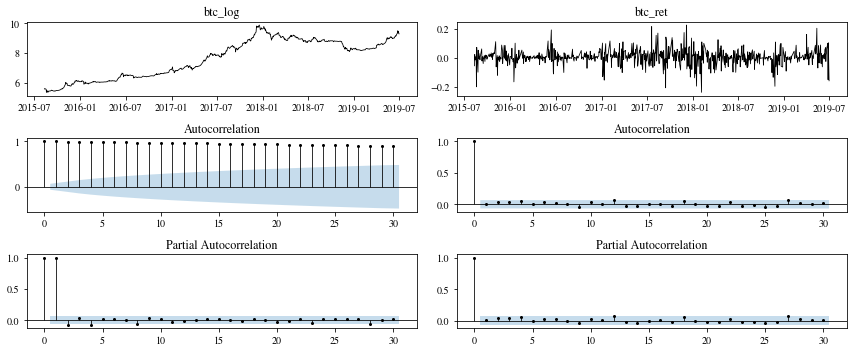

In [25]:
# plot btc_log and btc_ret with ACF and PACF, respectively
fig_1 = plot_acf_pacf(btc_log,btc_ret)

In [22]:
# save fig_1
fig_1.savefig(save_plot_to+'M2_fig_1.svg',format='svg',bbox_inches='tight',pad_inches = 0)

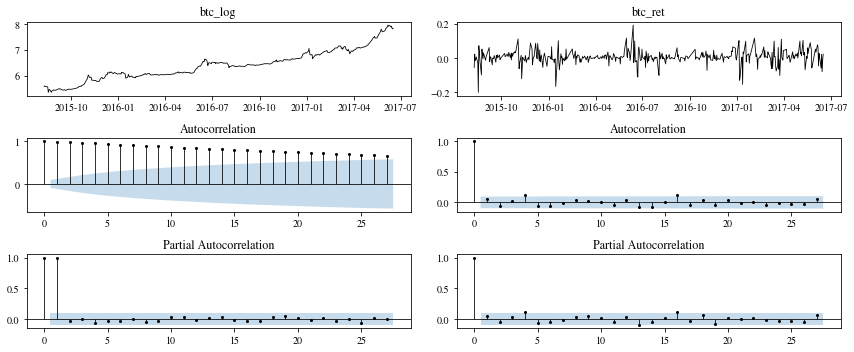

In [26]:
# plot btc_pre_log and btc_pre_ret with ACF and PACF, respectively
fig_1_pre = plot_acf_pacf(btc_pre_log,btc_pre_ret)

In [14]:
# save fig_1_pre
fig_1_pre.savefig(save_plot_to+'M2_pre_fig_1.svg',format='svg',bbox_inches='tight',pad_inches = 0)


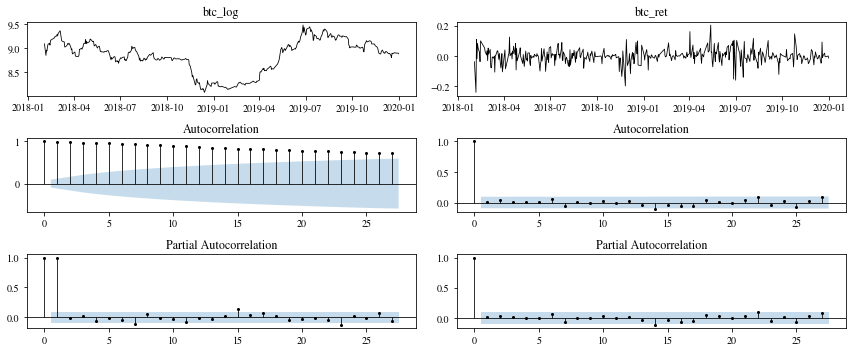

In [27]:
# plot btc_post_log and btc_post_ret with ACF and PACF, respectively
fig_1_post = plot_acf_pacf(btc_post_log,btc_post_ret)

In [16]:
# save fig_1_post
fig_1_post.savefig(save_plot_to+'M2_post_fig_1.svg',format='svg',bbox_inches='tight',pad_inches = 0)

In [14]:
# perform ADF and PP test on btc_log and btc_ret
stationarity_tests(btc_log,False)
stationarity_tests(btc_ret.iloc[1:],False)

Timeseries:	 btc_log 
    Augmented Dickey-Fuller Results   
Test Statistic                 -0.883
P-value                         0.794
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary. 

      Phillips-Perron Test (Z-tau)    
Test Statistic                 -0.931
P-value                         0.778
Lags                               21
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary. 



Timeseries:	 btc_ret 
    Augmented Dickey-Fuller Results   
Test Statistic                -29.318
P-value                         0.000
Lags                                0
-------------------------------------

Trend: Constant
Cr

In [54]:
# generate latex output for M2_stationarity tests.txt
stationarity_table_aslatex_from_df('M2_stationarity tests.txt')

In [15]:
# perform ADF and PP test on btc_pre_log and btc_pre_ret
stationarity_tests(btc_pre_log,False)
stationarity_tests(btc_pre_ret.iloc[1:],False)

Timeseries:	 btc_log 
    Augmented Dickey-Fuller Results   
Test Statistic                  0.852
P-value                         0.992
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary. 

      Phillips-Perron Test (Z-tau)    
Test Statistic                  0.896
P-value                         0.993
Lags                               18
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary. 



Timeseries:	 btc_ret 
    Augmented Dickey-Fuller Results   
Test Statistic                -19.618
P-value                         0.000
Lags                                0
-------------------------------------

Trend: Constant
Cr

In [19]:
# generate latex output for M2_pre_stationarity tests.txt
stationarity_table_aslatex_from_df('M2_pre_stationarity tests.txt')

\begin{tabular}{lrrl}
\hline
 Variable   &     ADF &      PP & \ensuremath{<}-2.86(5\%)   \\
\hline
 btc\_log    &   0.852 &   0.896 & nein         \\
 btc\_ret    & -19.618 & -19.598 & ja           \\
\hline
\end{tabular}


In [16]:
# perform ADF and PP test on btc_post_log and btc_post_ret
stationarity_tests(btc_post_log,False)
stationarity_tests(btc_post_ret.iloc[1:],False)

Timeseries:	 btc_log 
    Augmented Dickey-Fuller Results   
Test Statistic                 -1.545
P-value                         0.511
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary. 

      Phillips-Perron Test (Z-tau)    
Test Statistic                 -1.640
P-value                         0.462
Lags                               18
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary. 



Timeseries:	 btc_ret 
    Augmented Dickey-Fuller Results   
Test Statistic                -20.436
P-value                         0.000
Lags                                0
-------------------------------------

Trend: Constant
Cr

In [20]:
# generate latex output for M2_post_stationarity tests.txt
stationarity_table_aslatex_from_df('M2_post_stationarity tests.txt')

\begin{tabular}{lrrl}
\hline
 Variable   &     ADF &     PP & \ensuremath{<}-2.86(5\%)   \\
\hline
 btc\_log    &  -1.545 &  -1.64 & nein         \\
 btc\_ret    & -20.436 & -20.45 & ja           \\
\hline
\end{tabular}


In [ ]:
## ARCHIV: Genaue Testergebnisse für ADF und PP ##
# ADF- and PP- mit btc
from arch.unitroot import ADF, PhillipsPerron
adf = ADF(btc)
pp = PhillipsPerron(btc)
print(adf.summary().as_latex(),'\n\n\n', pp.summary().as_latex())

# ADF- and PP- mit btc_returns
from arch.unitroot import ADF, PhillipsPerron
adf = ADF(btc_returns[1:])
pp = PhillipsPerron(btc_returns[1:])
print(adf.summary().as_latex(),'\n\n\n', pp.summary().as_latex())

In [17]:
# obtain best auto arima model for btc_ret
btc_auto_arima = auto_arima_optimal_fit_of(btc_ret.iloc[1:],max_p=10,max_q=10)
btc_auto_arima.summary()

Performing stepwise search to minimize aic
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=-2848.296, BIC=-2838.718, Time=0.186 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=-2846.367, BIC=-2832.000, Time=0.146 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=-2846.363, BIC=-2831.996, Time=0.389 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=-2844.012, BIC=-2839.223, Time=0.100 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=-2844.365, BIC=-2825.209, Time=0.490 seconds
Total fit time: 1.329 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  888
Model:                        SARIMAX   Log Likelihood                1426.148
Date:                Thu, 01 Oct 2020   AIC                          -2848.296
Time:                        00:24:51   BIC                          -2838.718
Sample:                             0   HQIC                         -2844.635
                                - 888                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0041      0.002      2.505      0.012       0.001       0.007
sigma2         0.0024    6.4e-05     36.818      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               637.35
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               1.62   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [65]:
# generate and print latex output for btc_auto_arima model
print(btc_auto_arima.summary().as_latex())
                

In [18]:
# manually verify ARIMA(p,0,q) variations for btc_ret and print them as output
arima_fit_of(btc_ret.iloc[1:],max_p=2,max_q=2,latex=False)

Current order: 0,0,0
                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  888
Model:                        SARIMAX   Log Likelihood                1426.148
Date:                Thu, 01 Oct 2020   AIC                          -2848.296
Time:                        00:24:57   BIC                          -2838.718
Sample:                             0   HQIC                         -2844.635
                                - 888                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0041      0.002      2.505      0.012       0.001       0.007
sigma2         0.0024    6.4e-05     36.818      0.000       0.002       0.002
Ljung-Box (L1) (Q):           

In [19]:
# obtain best auto arima model for btc_pre_ret
btc_pre_auto_arima = auto_arima_optimal_fit_of(btc_pre_ret.iloc[1:],max_p=10,max_q=10)
btc_pre_auto_arima.summary()

Performing stepwise search to minimize aic
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=-1537.351, BIC=-1529.247, Time=0.154 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=-1536.361, BIC=-1524.204, Time=0.200 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=-1536.483, BIC=-1524.327, Time=0.338 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=-1532.114, BIC=-1528.062, Time=0.061 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=-1534.951, BIC=-1518.743, Time=0.540 seconds
Total fit time: 1.307 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  425
Model:                        SARIMAX   Log Likelihood                 770.676
Date:                Thu, 01 Oct 2020   AIC                          -1537.351
Time:                        00:25:01   BIC                          -1529.247
Sample:                             0   HQIC                         -1534.150
                                - 425                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0052      0.002      2.654      0.008       0.001       0.009
sigma2         0.0016   5.83e-05     26.702      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   1.01   Jarque-Bera (JB):               451.85
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               1.22   Skew:                            -0.49
Prob(H) (two-sided):                  0.23   Kurtosis:                         7.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
# generate and print latex output for btc_auto_arima model
print(btc_pre_auto_arima.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}          &        y         & \textbf{  No. Observations:  } &    425      \\
\textbf{Model:}                  &     SARIMAX      & \textbf{  Log Likelihood     } &  770.676    \\
\textbf{Date:}                   & Sun, 27 Sep 2020 & \textbf{  AIC                } & -1537.351   \\
\textbf{Time:}                   &     09:33:01     & \textbf{  BIC                } & -1529.247   \\
\textbf{Sample:}                 &        0         & \textbf{  HQIC               } & -1534.150   \\
\textbf{}                        &       - 425      & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                   & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$> |$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{intercept} &       0.0052  &        0.002     &     2.654  &         0.008        &        0.001    &        0.009     \\
\textbf{sigma2}    &   

In [20]:
# obtain best auto arima model for btc_post_ret
btc_post_auto_arima = auto_arima_optimal_fit_of(btc_post_ret.iloc[1:],max_p=10,max_q=10)
btc_post_auto_arima.summary()

Performing stepwise search to minimize aic
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=-1415.241, BIC=-1407.109, Time=0.124 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=-1413.313, BIC=-1401.114, Time=0.130 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=-1413.307, BIC=-1401.109, Time=0.303 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=-1417.178, BIC=-1413.112, Time=0.042 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=-1411.619, BIC=-1395.354, Time=0.231 seconds
Total fit time: 0.846 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  431
Model:                        SARIMAX   Log Likelihood                 709.589
Date:                Thu, 01 Oct 2020   AIC                          -1417.178
Time:                        00:25:05   BIC                          -1413.112
Sample:                             0   HQIC                         -1415.573
                                - 431                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0022   8.77e-05     24.789      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               250.59
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                            -0.29
Prob(H) (two-sided):                  0.78   Kurtosis:                         6.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
# generate and print latex output for btc_post_auto_arima model
print(btc_post_auto_arima.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}          &        y         & \textbf{  No. Observations:  } &    431      \\
\textbf{Model:}                  &     SARIMAX      & \textbf{  Log Likelihood     } &  709.589    \\
\textbf{Date:}                   & Sun, 27 Sep 2020 & \textbf{  AIC                } & -1417.178   \\
\textbf{Time:}                   &     09:37:26     & \textbf{  BIC                } & -1413.112   \\
\textbf{Sample:}                 &        0         & \textbf{  HQIC               } & -1415.573   \\
\textbf{}                        &       - 431      & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$> |$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{sigma2} &       0.0022  &     8.77e-05     &    24.789  &         0.000        &        0.002    &        0.002     \\
\bottomrule
\end{tabular}
\be

In [21]:
# rolling prediction with ARIMA(0,0,0) for btc
btc_arima_pred_result = arima_rolling_forecast(btc,0,0)
# printout mse and ausreisser
print('mse:\t\t', btc_arima_pred_result[0])
print('ausreisser:\t', btc_arima_pred_result[1])

mse:		 433.783168037022
ausreisser:	 14


In [27]:
# plot arima(0,0,0) rolling forecast for btc_ret
fig_2 = plot_arima_pred_result(btc,btc_train,btc_test,btc_arima_pred_result)

In [28]:
# save fig_2
fig_2.savefig(save_plot_to+'M2_fig_2.svg',format='svg',bbox_inches='tight',pad_inches = 0)

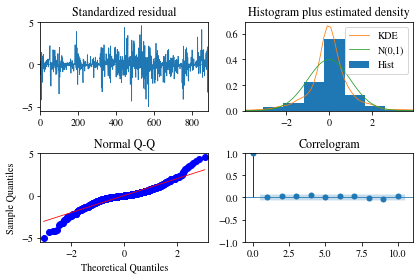

In [22]:
# plot diagnostics for ARIMA(0,0,0) for btc_ret and save as fig_3
arima_model = pm.ARIMA(order=(0,0,0))
arima_fitted = arima_model.fit(y=btc_ret.iloc[1:], disp=False)
arima_fitted.plot_diagnostics()
plt.tight_layout()
#fig.set_size_inches(12,5)
plt.savefig(save_plot_to+'M2_fig_3.svg',format='svg',bbox_inches='tight', pad_inches = 0)

In [23]:
# rolling prediction with ARIMA(0,0,0) for btc_pre
btc_pre_arima_pred_result = arima_rolling_forecast(btc_pre,0,0)
# printout mse and ausreisser
print('mse_pre:\t\t', btc_pre_arima_pred_result[0])
print('ausreisser_pre:\t', btc_pre_arima_pred_result[1])

mse_pre:		 295.28800697915545
ausreisser_pre:	 14


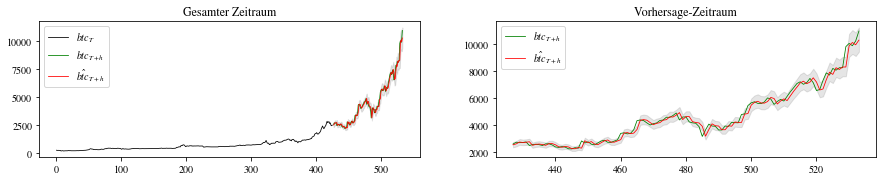

In [24]:
# plot arima(0,0,0) rolling forecast for btc_pre_ret
fig_2_pre = plot_arima_pred_result(btc_pre,btc_pre_train,btc_pre_test,btc_pre_arima_pred_result)

In [29]:
# save fig_2_pre
fig_2_pre.savefig(save_plot_to+'M2_pre_fig_2.svg',format='svg',bbox_inches='tight',pad_inches = 0)

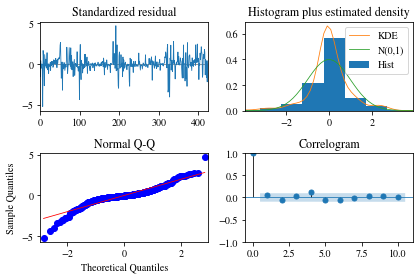

In [29]:
# plot diagnostics for ARIMA(0,0,0) for btc_pre_ret and save as fig_3_pre
arima_pre_model = pm.ARIMA(order=(0,0,0))
arima_pre_fitted = arima_pre_model.fit(y=btc_pre_ret.iloc[1:], disp=False)
arima_pre_fitted.plot_diagnostics()
plt.tight_layout()
#fig.set_size_inches(12,5)
plt.savefig(save_plot_to+'M2_pre_fig_3.svg',format='svg',bbox_inches='tight', pad_inches = 0)

In [31]:
# rolling prediction with ARIMA(0,0,0) for btc_post
btc_post_arima_pred_result = arima_rolling_forecast(btc_post,0,0)
# printout mse and ausreisser
print('mse_post:\t\t', btc_post_arima_pred_result[0])
print('ausreisser_post:\t', btc_post_arima_pred_result[1])

mse_post:		 460.77989580556846
ausreisser_post:	 8


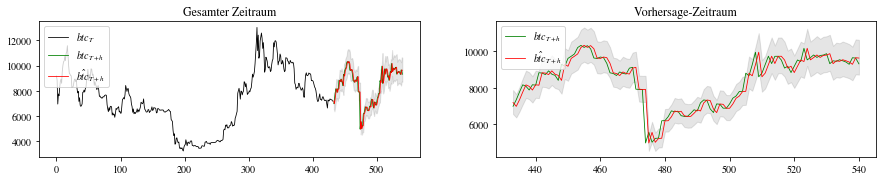

In [32]:
# plot arima(0,0,0) rolling forecast for btc_post_ret
fig_2_post = plot_arima_pred_result(btc_post,btc_post_train,btc_post_test,btc_post_arima_pred_result)

In [33]:
# save fig_2_post
fig_2_post.savefig(save_plot_to+'M2_post_fig_2.svg',format='svg',bbox_inches='tight',pad_inches = 0)

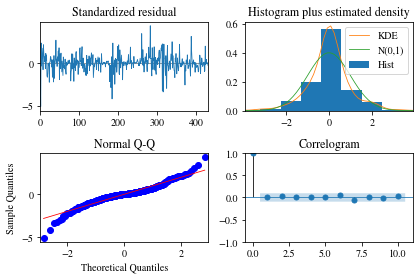

In [33]:
# plot diagnostics for ARIMA(0,0,0) for btc_post_ret and save as fig_3_post
arima_post_model = pm.ARIMA(order=(0,0,0))
arima_post_fitted = arima_post_model.fit(y=btc_post_ret.iloc[1:], disp=False)
arima_post_fitted.plot_diagnostics()
plt.tight_layout()
#fig.set_size_inches(12,5)
plt.savefig(save_plot_to+'M2_post_fig_3.svg',format='svg',bbox_inches='tight', pad_inches = 0)


In [36]:
# test heteroskedast.
from statsmodels.tsa.arima_model import ARIMA
arima_model = ARIMA(endog=btc_ret.iloc[1:],order=(0,1,0))
arima_fitted = arima_model.fit()